## Imports and Variables

In [551]:
import csv
import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime as dt

import matplotlib.pylab as plt
import matplotlib

from pandas import DataFrame

%matplotlib inline

In [596]:
window_size = 5
used_params = 4

close_value = 0
open_value = 1
high_value = 2
low_value = 3

## Read data and Preprocessing

Read in the historic stock data of MSFT (Microsoft) of the last 10 years.
Treat header and data seperated

In [553]:
data = []
header = []

with open('data/HistoricalQuotes.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:       
        try:
            row[0] = datetime.strptime(row[0], '%Y/%m/%d')
        except:
            print ('Could not convert ' + row[0] + ': skip')
        row.pop(2) #Remove Volume value since it dramatically affects the score
        data.append(row)
        
header.append(data.pop(0))

print('Loose latest entry: ' + str(data.pop(0)))

Could not convert date: skip
Could not convert 11:41: skip
Loose latest entry: ['11:41', '60.03', '60.43', '60.46', '59.80']


In [554]:
DataFrame(data, columns = header[0])[0:10]

,date,close,open,high,low
0,2016-12-05,60.2200,59.7000,60.5850,59.5600
1,2016-12-02,59.2500,59.0800,59.4700,58.8000
2,2016-12-01,59.2000,60.1100,60.1500,58.9350
3,2016-11-30,60.2600,60.8600,61.1800,60.2150
4,2016-11-29,61.0900,60.6500,61.4100,60.5200
5,2016-11-28,60.6100,60.3400,61.0200,60.2100
6,2016-11-25,60.5300,60.3000,60.5300,60.1300
7,2016-11-23,60.4000,61.0100,61.1000,60.2500
8,2016-11-22,61.1200,60.9800,61.2600,60.8050
9,2016-11-21,60.8600,60.5000,60.9700,60.4200


## Create Timeline

Function to build a timeline using a given window

In [555]:
def buid_timeline_data(data, window):
    timeline = []
    labels = []
    
    timeline_wd = []
    labels_wd = []
    
    timeline_element = []
    current_window = 0
    
    reverse_data = list(reversed(data))
    reverse_data.pop(len(reverse_data)-1) # Delete the last day due to different format
    
    for i in range(len(reverse_data)):       
        if(i+window+1 < len(reverse_data)): 
            timeline_element, label, timeline_element_wd, label_wd = get_timeline_data(reverse_data, window, i)
            
            timeline.append(timeline_element)
            timeline_wd.append(timeline_element_wd)
            labels.append(label)
            labels_wd.append(label_wd)
            
    return timeline, labels, timeline_wd, labels_wd

In [556]:
def get_timeline_data(data, window, current_index):   
    timeline_element = []
    timeline_element_wd = []
    
    #Get the Data for each stock day
    for i in range(window):  
        timeline_element += data[current_index+i][1:]
        timeline_element_wd += data[current_index+i]
    
    label = data[current_index+window][1:]
    label_wd = data[current_index+window]
    
    return timeline_element, label, timeline_element_wd, label_wd

In [557]:
timeline, labels, timeline_wd, labels_wd = buid_timeline_data(data, window_size)

#Data without date
timeline = np.array(timeline).astype(float) 
labels = np.array(labels).astype(float)
#Data with date
timeline_wd = np.array(timeline_wd)
labels_wd = np.array(labels_wd)

print('Shape of Timeline: ' + str(timeline.shape))
print('Shape of Labels: ' + str(labels.shape))

Shape of Timeline: (2511, 20)
Shape of Labels: (2511, 4)


In [558]:
DataFrame(timeline_wd, columns=header[0]*window_size)[:5]

,date,close,open,high,low,date,close,open,high,low,...,date,close,open,high,low,date,close,open,high,low
0,2006-12-05 00:00:00,29.1300,29.3600,29.4000,29.0300,2006-12-06 00:00:00,28.9900,29.0950,29.1300,28.8700,...,2006-12-08 00:00:00,29.4000,28.8200,29.4000,28.8000,2006-12-11 00:00:00,29.5400,29.1850,29.7500,29.1100
1,2006-12-06 00:00:00,28.9900,29.0950,29.1300,28.8700,2006-12-07 00:00:00,28.8500,28.9600,29.0700,28.8100,...,2006-12-11 00:00:00,29.5400,29.1850,29.7500,29.1100,2006-12-12 00:00:00,29.4300,29.5200,29.6300,29.2200
2,2006-12-07 00:00:00,28.8500,28.9600,29.0700,28.8100,2006-12-08 00:00:00,29.4000,28.8200,29.4000,28.8000,...,2006-12-12 00:00:00,29.4300,29.5200,29.6300,29.2200,2006-12-13 00:00:00,29.5500,29.6000,29.6000,29.3200
3,2006-12-08 00:00:00,29.4000,28.8200,29.4000,28.8000,2006-12-11 00:00:00,29.5400,29.1850,29.7500,29.1100,...,2006-12-13 00:00:00,29.5500,29.6000,29.6000,29.3200,2006-12-14 00:00:00,30.0700,29.5450,30.0801,29.5200
4,2006-12-11 00:00:00,29.5400,29.1850,29.7500,29.1100,2006-12-12 00:00:00,29.4300,29.5200,29.6300,29.2200,...,2006-12-14 00:00:00,30.0700,29.5450,30.0801,29.5200,2006-12-15 00:00:00,30.1900,30.1450,30.2300,30.0300


## Using a Support Vector Machine to calculate the Regression

The score metric returns the coefficient of determination R² of the prediction.
The coefficient R² is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred) * 2).sum() and v is the residual sum of squares ((y_true - y_true.mean()) * 2).sum(). Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0. [(according to sklearn)](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [559]:
X_train, X_test, y_train, y_test = train_test_split(timeline, labels,  test_size=0.33)

#close
regressor_close = SVR(C=10)
regressor_close.fit(X_train, y_train[:,close_value])
#open
regressor_open = SVR()
regressor_open.fit(X_train, y_train[:,open_value])
#high
regressor_high = SVR()
regressor_high.fit(X_train, y_train[:,high_value])
#low
regressor_low = SVR()
regressor_low.fit(X_train, y_train[:,low_value])

score = regressor_close.score(X_test, y_test[:,close_value])
print ('Close Score: ' + str(score))

score = regressor_open.score(X_test, y_test[:,open_Value])
print ('Open Score: ' + str(score))

score = regressor_high.score(X_test, y_test[:,high_value])
print ('High Score: ' + str(score))

score = regressor_low.score(X_test, y_test[:,low_value])
print ('Low Score: ' + str(score))

Close Score: 0.976487817407
Open Score: 0.925811086797
High Score: 0.924469346851
Low Score: 0.923365912092


## Visualize Prediction vs. Real Data

Visualize the daily High value

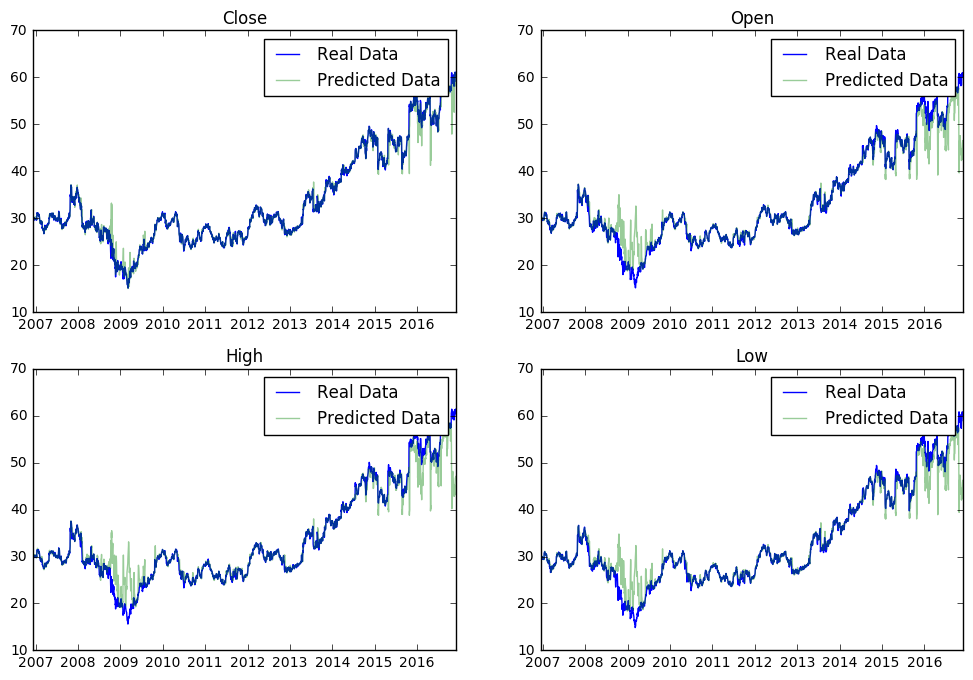

In [599]:
dates = matplotlib.dates.date2num(labels_wd[:,0])

plt.figure(num=None, figsize=(12, 8), dpi=80)

plt.subplot(221) 
plt.plot_date(dates, labels[:,close_value],'b-', c='blue', label='Real Data')
plt.plot_date(dates, regressor_close.predict(timeline),'b-', c='green', alpha=0.4, label='Predicted Data')
plt.title('Close') 
plt.legend()

plt.subplot(222) 
plt.plot_date(dates, labels[:,open_value],'b-', c='blue', label='Real Data')
plt.plot_date(dates, regressor_open.predict(timeline),'b-', c='green', alpha=0.4, label='Predicted Data')
plt.legend()
plt.title('Open') 

plt.subplot(223) 
plt.plot_date(dates, labels[:,high_value],'b-', c='blue', label='Real Data')
plt.plot_date(dates, regressor_high.predict(timeline),'b-', c='green', alpha=0.4, label='Predicted Data')
plt.legend()
plt.title('High') 

plt.subplot(224) 
plt.plot_date(dates, labels[:,low_value],'b-', c='blue', label='Real Data')
plt.plot_date(dates, regressor_low.predict(timeline),'b-', c='green', alpha=0.4, label='Predicted Data')
plt.legend()
plt.title('Low') 

plt.show()

## Predict Future Day
This is achieved by predicting following procedure:
* Predict the next possible day given the last possible timeline element
* Using the value of this prediciton to predict the next day
* Repeat until the desired day is reached

Assumptions are getting worse the farther they reach the future

In [600]:
def get_values_by_timeline(timeline_element):
    close_ = regressor_close.predict(timeline_element)
    open_ = regressor_open.predict(timeline_element)
    high_ = regressor_high.predict(timeline_element)
    low_ = regressor_low.predict(timeline_element)
    
    return [close_[0], open_[0], high_[0], low_[0]]

In [601]:
def get_previous_valid_date(last_day):
    previous_day = last_day - dt.timedelta(days=1)
    """ Skip Weekends where the stock exchange is closed """
    if (previous_day.weekday() == 6): previous_day = previous_day - dt.timedelta(days=2)
    if (previous_day.weekday() == 5): previous_day = previous_day - dt.timedelta(days=1)
        
    return previous_day

In [602]:
def get_next_valid_date(last_day):
    next_day = last_day + dt.timedelta(days=1)
    """ Skip Weekends where the stock exchange is closed """
    if (next_day.weekday() == 6): next_day = next_day + dt.timedelta(days=1)
    if (next_day.weekday() == 5): next_day = next_day + dt.timedelta(days=2)
        
    return next_day

In [612]:
def build_timeline_element(copy_timeline, last_index, last_day):
    """ Search for the other timeline elements to build the required window size"""
    for i in range(window_size):
        last_index = last_index - i
        last_day = get_previous_valid_date(last_day)
        if i==0:
            values = get_values_by_timeline(copy_timeline[last_index].reshape(1, -1))
            values_wd = values[:] # None referenced copy
            
            timeline_element = values
            values_wd.insert(0, last_day)
            timeline_element_wd = values_wd
        else:
            values = get_values_by_timeline(copy_timeline[last_index].reshape(1, -1))
            values_wd = values[:] # None referenced copy
            
            timeline_element = values + timeline_element
            values_wd.insert(0, last_day)
            timeline_element_wd = values_wd + timeline_element_wd
    
    """Convert to numpy array """   
    timeline_element = np.array([timeline_element])
    timeline_element_wd = np.array([timeline_element_wd])
    
    return timeline_element, timeline_element_wd

In [613]:
def build_last_label(copy_timeline, last_day):
    label = get_values_by_timeline(copy_timeline[-1].reshape(1, -1))
    label_wd = label[:] # None referenced copy

    label_wd.insert(0, last_day)
    
    """ Convert to numpy array """
    label = np.array([label])
    label_wd = np.array([label_wd])
    
    return label, label_wd

In [614]:
def predict_by_day(date):
    last_day = labels_wd[-1][0]
    date_delta = date-last_day
    
    copy_timeline = timeline[:]
    new_timeline = np.empty((0,window_size*used_params)) 
    new_timeline_wd = np.empty((0,window_size*(used_params+1)))
    new_labels = np.empty((0,used_params)) 
    new_labels_wd = np.empty((0,used_params+1))
    
    # Create a copies without a reference of the input data so that the orginal is not altered    
    """ Iterate till the desired date is reached """
    while (last_day < date):
        last_index = len(copy_timeline)-1
        """ Generate timeline element and append the it to the timeline """ 
        timeline_element, timeline_element_wd = build_timeline_element(copy_timeline, last_index, last_day)
        copy_timeline = np.append(copy_timeline, timeline_element, axis=0) 
        new_timeline = np.append(new_timeline, timeline_element, axis=0)
        new_timeline_wd = np.append(new_timeline_wd, timeline_element_wd, axis=0)
        """ Get next day """
        last_day = get_next_valid_date(last_day)
        """ Create the corrosponding label to the timeline element """       
        label, label_wd = build_last_label(copy_timeline, last_day)
        new_labels = np.append(new_labels, label, axis=0)
        new_labels_wd = np.append(new_labels_wd, label_wd, axis=0)
    
    print ('Predicted ' + str(date_delta.days) + ' days')
    result = get_values_by_timeline(new_timeline[-1].reshape(1, -1))
    return result, new_labels_wd, new_timeline_wd, new_timeline, new_labels

In [621]:
search_date = labels_wd[-1][0]+ dt.timedelta(days=100)
print ('Search results for day ' + str(search_date) + ' into the future')
result, gen_lables_wd, gen_timeline_wd, gen_timeline, gen_lables = predict_by_day(search_date)
DataFrame(gen_lables_wd[-1].reshape(1,5), columns=header)

Search results for day 2017-03-11 00:00:00 into the future
Predicted 100 days


,date,close,open,high,low
0,2017-03-13 00:00:00,37.833,37.7879,37.9909,37.5371
